# COMP4167 Natural Language Processing
# Practical II
# Neural Machine Translation (encoder/decoder with attention)

In this notebook we will practice some of the methods discusssed in the lectures to address an NLP task, transation using sequence to sequence modelling.

In this notebook you will:
- Pre-process English-French langauge pairs
- Build attention based Seq2Seq model to translate between French and English
- Visualise attention 

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
        
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

Loading data files
==================

The data for this project is a set of few thousands of English to
French translation pairs. The data is available in ``data/eng-fra.txt``.

The file is a tab separated list of translation pairs, For example:

    I am cold.    Je suis froid.



- For simplicity, we will model only the words within the training set.
- We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called ``Lang`` which has word → index (``word2index``) and index → word (``index2word``) dictionaries, as well as a count of each word ``word2count`` to use for replacing rare words.

In [3]:
# We add start and end of sentence tokens
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Data Pre-processing
The file is in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most
punctuation.




In [4]:
def unicodeToAscii(s):
    '''Turn a Unicode string to plain ASCII'''
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    '''Lowercase, trim, and remove non-letter characters'''
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The file contians all English → French pairs, if we want to translate from French → English we will use the ``reverse`` flag to reverse the pairs.


In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize (對應，英文vs法文  成一個pair，而不是兩個英文字成pair)
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. We will set the maximum length to 10 words including
ending punctuation, and we will filter to sentences that translate to
the form "I am" or "He is" etc.


In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

## Pre-Process pipeline
The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalise text, filter by length and content
-  Make word lists from sentences in pairs




In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['je suis convaincu de son innocence .', 'i am convinced of his innocence .']


The Seq2Seq Model
=================

For our Seq2Seq model we will build an RNN based encoder and decoder.



## The Encoder

- The encoder of a seq2seq model is an RNN-based network. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

- The RNN is implemented here as a GRU, but can also be implemented as LSTM. 

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers): 
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.




### Simple Decoder (without attention)

In the simplest seq2seq decoder we use only the last output of the encoder. This last output is called the *context vector* as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start of sentence ``<SOS>`` token, and the first hidden state is the context vector (the encoder's last hidden state).


In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers): # implement the RNN's forward pass
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## Attention Decoder

If only the context vector is passed betweeen the encoder and decoder, that single vector is a bootleneck of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs. First we calculate a set of *attention weights*. These will be multiplied by the encoder output vectors to create a weighted sum. The result should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Calculating the attention weights is done with another feed-forward layer ``attn``, using the decoder's input and hidden state as inputs. Because there are sentences of various sizes in the training data, we will choose a maximum sentence length that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.


In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_output = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))# perform batch matrix multiplication

        output = torch.cat((embedded[0], attn_output[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the words in the source sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.


In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

## Training the Model


To train we feed the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the ``<SOS>`` token as its first input, and the last hidden state of the encoder as its first hidden state.

During trianing the decoder uses the target tokens ground truth (not the one predected by the decoder at time step t-1).


In [12]:

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

    #Feed the target as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        loss += criterion(decoder_output, target_variable[di])
        decoder_input = target_variable[di]  # Teacher forcing
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## Training Pipeline

-  Start a timer
-  Initialise optimisers and criterion (loss)
-  Create set of training pairs
-  define empty losses array for plotting

Then we call ``train`` many times and print the progress (%
of examples, time so far, estimated time) and average loss.




In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
 
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

In evaluation there are no targets sentences (ground truth).
We feed the decoder's predictions back to itself for each time step.
For simplicity, every time the decoder predicts a word we add it to the output string in a greedy manner, and if it
predicts the EOS token we stop. We also store the decoder's
attention outputs for plotting them later on.




In [16]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[int(ni)])
        
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output.




In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================


Remember that the input sentences were heavily preprocessed. For this small dataset we can use relatively small network of 256 hidden nodes and a single GRU layer.


2m 6s (- 29m 27s) (5000 6%) 2.6507
4m 7s (- 26m 47s) (10000 13%) 1.9974
6m 18s (- 25m 15s) (15000 20%) 1.6949
8m 37s (- 23m 43s) (20000 26%) 1.4582
10m 38s (- 21m 16s) (25000 33%) 1.2581
13m 9s (- 19m 44s) (30000 40%) 1.1035
15m 16s (- 17m 27s) (35000 46%) 0.9902
17m 29s (- 15m 18s) (40000 53%) 0.8759
19m 36s (- 13m 4s) (45000 60%) 0.7718
22m 5s (- 11m 2s) (50000 66%) 0.7013
24m 15s (- 8m 49s) (55000 73%) 0.6301
26m 19s (- 6m 34s) (60000 80%) 0.5537
28m 16s (- 4m 21s) (65000 86%) 0.4987
30m 16s (- 2m 9s) (70000 93%) 0.4613
32m 23s (- 0m 0s) (75000 100%) 0.4124


<Figure size 640x480 with 0 Axes>

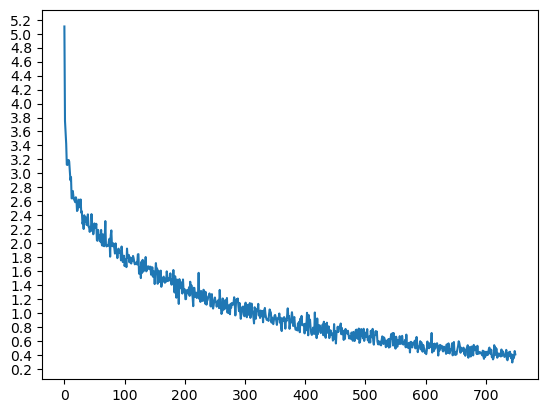

In [18]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [19]:
# Randomly select some samples
evaluateRandomly(encoder1, attn_decoder1)

> vous n etes pas gros .
= you re not fat .
< you re not fat . <EOS>

> elle a cinq ans de moins que moi .
= she s five years younger than me .
< she is five years younger than me . <EOS>

> je suis a la diete .
= i m fasting .
< i m fasting . <EOS>

> je suis submerge de travail .
= i am swamped with work .
< i am in her work . <EOS>

> ce sont toutes des voleuses .
= they re all thieves .
< they re all liars . <EOS>

> tu es une veritable amie .
= you re a true friend .
< you re a wonderful friend . <EOS>

> je ne suis pas tout a fait surprise .
= i m not exactly surprised .
< i m not all set . <EOS>

> ils menent grand train .
= they re eating high on the hog .
< they re coming apples . <EOS>

> il est sur de reussir l examen .
= he is sure to pass the exam .
< he is sure about the exam . <EOS>

> elle est deux ans plus vieille que toi .
= she is two years older than you .
< she is two years older than you . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its interpretable
outputs. 

You can run ``plt.matshow(attentions)`` to see attention output as a matrix, with the columns being input steps and rows being
output steps:




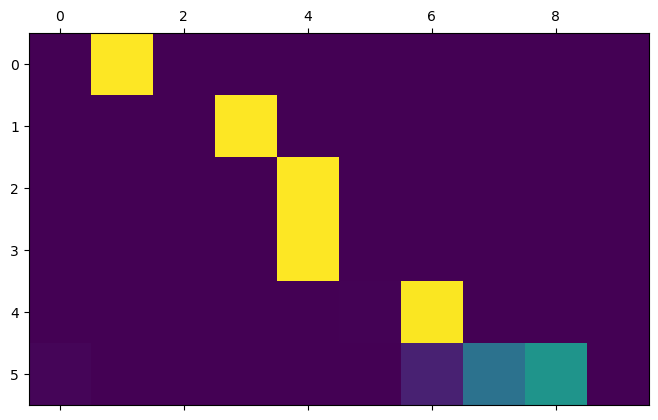

In [20]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

Now we will add axes
and labels.




input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


C:\Users\USER\AppData\Local\Temp\ipykernel_22568\744067545.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\USER\AppData\Local\Temp\ipykernel_22568\744067545.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


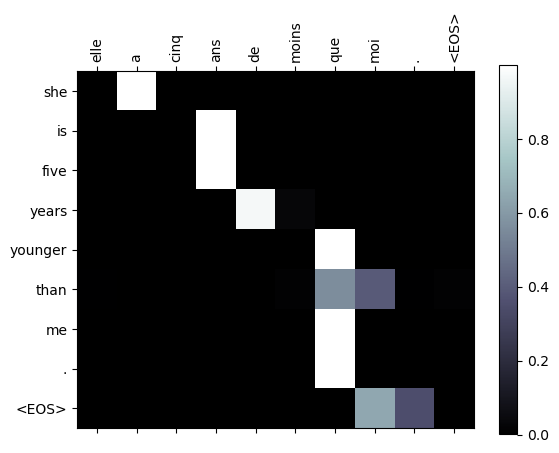

input = elle est trop petit .
output = she s too fat . <EOS>


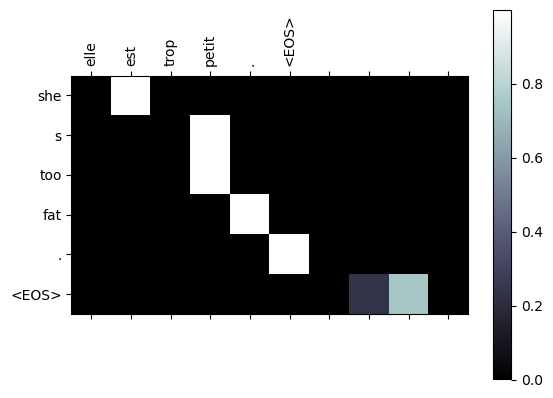

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


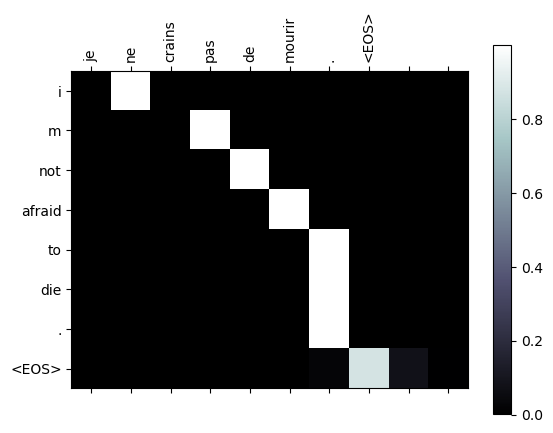

input = c est un jeune directeur plein de talent .
output = he s a talented man . <EOS>


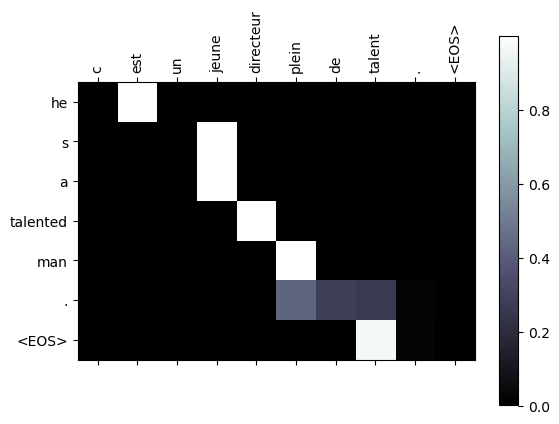

In [21]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

Exercises
=========
-  Try to test the model with different sentence pairs.
-  Suggest possible model improvements.
-  Can you replace the greedy decoding with Beam search decoding?
-  Try to swap between your source language and target language. 
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  Replace the GRU with LSTM and analyse the difference in performance.


